In [143]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

In [144]:
""" 
Remove the objects with failed redshfit classifications.
First appplying their ZWARN flag, then with the photo-z quality flag.



had to reapply the download code  so were the spectra actually being used??
"""

# Apply ZWARN Flag cut
crossmatch = crossmatch[crossmatch['ZWARN'] == 0]
print('zwarn applied:',len(crossmatch))

# Create photo-z quality flag
crossmatch['Z_CHECK']= (crossmatch['Z']-crossmatch['Z_BEST_1'])/(1+crossmatch['Z'])
crossmatch['Z_FAILURE'] = 0  
crossmatch['Z_FAILURE'][abs(crossmatch['Z_CHECK']) > 0.1] = 1 

z_fail = crossmatch[crossmatch['Z_FAILURE'] == 1]
print('z failure:',len(z_fail))

print(len(z_fail[z_fail['Z'] < 0]))

# Apply photo-z quality flag
crossmatch = crossmatch[crossmatch['Z_FAILURE'] == 0]
print(len(crossmatch))
print(len(crossmatch[crossmatch['Z'] < 0]))





zwarn applied: 8054
z failure: 521
35
7533
27


## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [24]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547

"""


Overall_class = 'z_fail'
my_table = z_fail
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv3' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 's

In [21]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

def resample_col(wave_bound, z_bound):
    """
    The spectra are resampled onto a common grid in the stacking process.
    This gives the resampled rest-frame colour boundaries for plotting.

    """
    wave_rest = wave_bound / (1+z_bound)

    return wave_rest

In [22]:
#stacking functions


# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    b_end, r_start, r_end, z_start = [], [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        
        # Prnt the resampled rest-frame wavelength boundaries
        b_start = resample_col(coadd_spec.wave['b'][0],z)
        b_end1 = resample_col(coadd_spec.wave['b'][-1],z) 
        r_start1 = resample_col(coadd_spec.wave['r'][0],z)
        r_end1 = resample_col(coadd_spec.wave['r'][-1],z)
        z_start1 = resample_col(coadd_spec.wave['z'][0],z)
        z_end = resample_col(coadd_spec.wave['z'][-1],z)
        #print('range 1:', coadd_spec.wave['z'][-1]-coadd_spec.wave['b'][0])
        #print('range new:', z_end-b_start)
        #print('B start 1:',coadd_spec.wave['b'][0],'B end 1:', coadd_spec.wave['b'][-1],'R start 1:', coadd_spec.wave['r'][0], 'R end 1:', coadd_spec.wave['r'][-1], 'Z start', coadd_spec.wave['z'][0], 'Z end', coadd_spec.wave['z'][-1])
        #print('B start:',b_start,'B end:', b_end,'R start:', r_start, 'R end:', r_end, 'Z start:', z_start, 'Z end:', z_end)
        b_end.append(b_end1)
        r_start.append(r_start1)
        r_end.append(r_end1)
        z_start.append(z_start1)
        

        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()
    print('b end min:', np.min(b_end))
    print('b end max:', np.max(b_end))
    print('r start min:', np.min(r_start))
    print('r start max:', np.max(r_start))
    print('r end min:', np.min(r_end))
    print('r end max:', np.max(r_end))
    print('z start min:', np.min(z_start))
    print('z start max:', np.max(z_start))
    print('z min:', np.min(z))
    print('z max:', np.max(z))

    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [25]:

"""

Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547



"""

# Select varibale to sort by
#Mass_median or Total_flux from LOFAR?

#var_bin = 'Mass_median'
#crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]

Overall_class = 'Z_Failure'  # Check this is only inputting to f-string captions and not functions
my_table = z_fail
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


Spec=get_spectra(my_table,search_column_name,search_values) #extracts relevant spectra

Stack = get_stack(Spec) #stacks spectra

# Save stack to CSV
stack_df = pd.DataFrame({'wave_spec': Stack['zbin=0']['wln'], 'flux_spec': Stack['zbin=0']['flux']})
stack_df.to_csv(f'{Overall_class}_stack.csv', index=False)




Number of spectra = 521
INFO:spectra.py:372:read_spectra: iotime 3.663 sec to read coadd-sv3-dark-11520.fits at 2024-01-25T12:23:31.698696


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1948/3045018241.py:98: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 3.164 sec to read coadd-sv3-dark-11520.fits at 2024-01-25T12:23:38.572582
INFO:spectra.py:372:read_spectra: iotime 3.408 sec to read coadd-sv3-dark-11520.fits at 2024-01-25T12:23:46.329837


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1948/437957867.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1948/437957867.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1948/437957867.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_1948/437957867.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 0.747 sec to read coadd-sv1-other-11520.fits at 2024-01-25T12:23:50.749002
INFO:spectra.py:372:read_spectra: iotime 0.691 sec to read coadd-sv1-other-11520.fits at 2024-01-25T12:23:52.004020
INFO:spectra.py:372:read_spectra: iotime 3.592 sec to read coadd-sv3-dark-11520.fits at 2024-01-25T12:23:55.768288
INFO:spectra.py:372:read_spectra: iotime 2.782 sec to read coadd-sv3-bright-11520.fits at 2024-01-25T12:24:02.376141
INFO:spectra.py:372:read_spectra: iotime 1.156 sec to read coadd-sv1-other-11520.fits at 2024-01-25T12:24:05.947513
INFO:spectra.py:372:read_spectra: iotime 0.667 sec to read coadd-sv1-other-11520.fits at 2024-01-25T12:24:08.019402
INFO:spectra.py:372:read_spectra: iotime 0.824 sec to read coadd-sv1-other-11520.fits at 2024-01-25T12:24:09.843749
INFO:spectra.py:372:read_spectra: iotime 2.577 sec to read coadd-sv3-bright-11520.fits at 2024-01-25T12:24:12.671163
INFO:spectra.py:372:read_spectra: iotime 2.580 sec to read coadd-sv3-br

In [250]:
Overall_class = 'Z_Failure'  # Check this is only inputting to f-string captions and not functions
my_table = z_fail
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])

# Read stack.csv
stack_df = pd.read_csv(f'{Overall_class}_stack.csv')
stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)

wln = stack[0] 
flux = stack[1]

(0.0, 70.0)

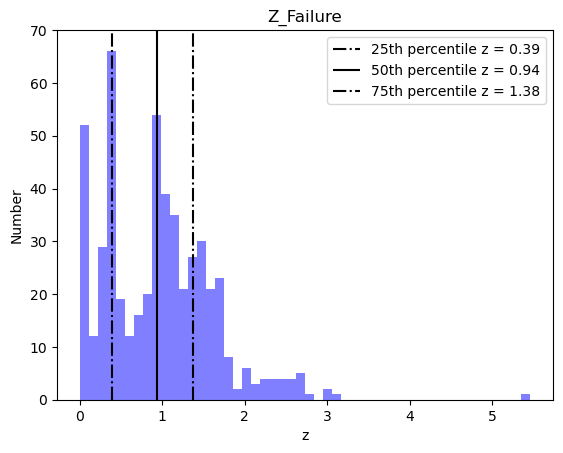

In [251]:
percentile_1 = 25
percentile_2 = 50
percentile_3 = 75
z_cut_1 = np.percentile(my_table['Z'], percentile_1)
z_cut_2 = np.percentile(my_table['Z'], percentile_2)
z_cut_3 = np.percentile(my_table['Z'], percentile_3)

plt.hist(my_table['Z'], bins=50, color='blue', alpha = 0.5)
plt.xlabel('z')
plt.ylabel('Number')
plt.title(f'{Overall_class}')
plt.vlines(z_cut_1, ymin=0, ymax=70, colors='black', linestyles='-.', label = f'{percentile_1}th percentile z = {z_cut_1:.2f}')
plt.vlines(z_cut_2, ymin=0, ymax=70, colors='black', linestyles='-', label = f'{percentile_2}th percentile z = {z_cut_2:.2f}')
plt.vlines(z_cut_3, ymin=0, ymax=70, colors='black', linestyles='-.', label = f'{percentile_3}th percentile z = {z_cut_3:.2f}')
plt.legend()
plt.ylim(0,70)
#plt.xlim(0,2)



In [252]:
print(np.min(my_table['Z']))

-0.0013972723321373673


In [130]:

# Stack spectra in to redshift bins  - need to alter
Stacks = get_stack(Spec, zbins=[[0.03,0.4],[0.4,0.9],[0.9,3.5]])

# Save stack to CSV
stacks_df_1 = pd.DataFrame({'wave_spec_1': Stacks['zbin=0']['wln'], 'flux_spec_1': Stacks['zbin=0']['flux']})
stacks_df_2 = pd.DataFrame({'wave_spec_2': Stacks['zbin=1']['wln'], 'flux_spec_2': Stacks['zbin=1']['flux']})
stacks_df_3 = pd.DataFrame({'wave_spec_3': Stacks['zbin=2']['wln'], 'flux_spec_3': Stacks['zbin=2']['flux']})
stacks_df_1.to_csv(f'{Overall_class}_stacks_1.csv', index=False)
stacks_df_2.to_csv(f'{Overall_class}_stacks_2.csv', index=False)    
stacks_df_3.to_csv(f'{Overall_class}_stacks_3.csv', index=False)


flux_spec: [array([-1.2029326 , -0.36947703,  0.41516915, ...,  0.66097915,
         0.47889709,  0.35918516])
 array([ 0.01728117,  2.96300483, -2.47771931, ...,  0.29218918,
         0.88923335,  0.97391623])
 array([35.66731262, 21.20654297, 25.50609589, ...,  3.14937067,
         3.80537319,  3.1327517 ])
 array([-3.06886411, -1.03531921, -3.38387012, ...,  0.32699862,
         0.37721926,  1.24712741])
 array([13.44944572, 13.21861267, 18.5052166 , ...,  1.42480195,
         1.32904768,  1.32937276])
 array([0.52511346, 1.87205815, 5.14649105, ..., 0.66536218, 1.02620721,
        0.28953651])
 array([-0.81434143, -1.18465912, -0.77583653, ...,  0.19237612,
         0.10971051,  0.25416002])
 array([-0.44478646, -8.93789005,  7.67530107, ...,  0.66605681,
         0.80883157,  1.03564227])
 array([2.88179398, 4.37882662, 3.8176353 , ..., 1.01300585, 0.9496457 ,
        0.94571012])
 array([ 0.91330791, -9.07994175, -9.38861847, ...,  2.54176641,
         1.72638702,  2.62661982])
 

In [142]:
# Read stack.csv
stacks_df_1 = pd.read_csv(f'{Overall_class}_stacks_1.csv')
stacks_1 = (stacks_df_1['wave_spec_1'].values, stacks_df_1['flux_spec_1'].values)

wln_1 = stacks_1[0] 
flux_1 = stacks_1[1]

stacks_df_2 = pd.read_csv(f'{Overall_class}_stacks_2.csv')
stacks_2 = (stacks_df_2['wave_spec_2'].values, stacks_df_2['flux_spec_2'].values)

wln_2 = stacks_2[0]
flux_2 = stacks_2[1]

stacks_df_3 = pd.read_csv(f'{Overall_class}_stacks_3.csv')
stacks_3 = (stacks_df_3['wave_spec_3'].values, stacks_df_3['flux_spec_3'].values)

wln_3 = stacks_3[0]
flux_3 = stacks_3[1]


FileNotFoundError: [Errno 2] No such file or directory: 'Z_Failure_stacks_1.csv'

## Plot Stacked Spectra

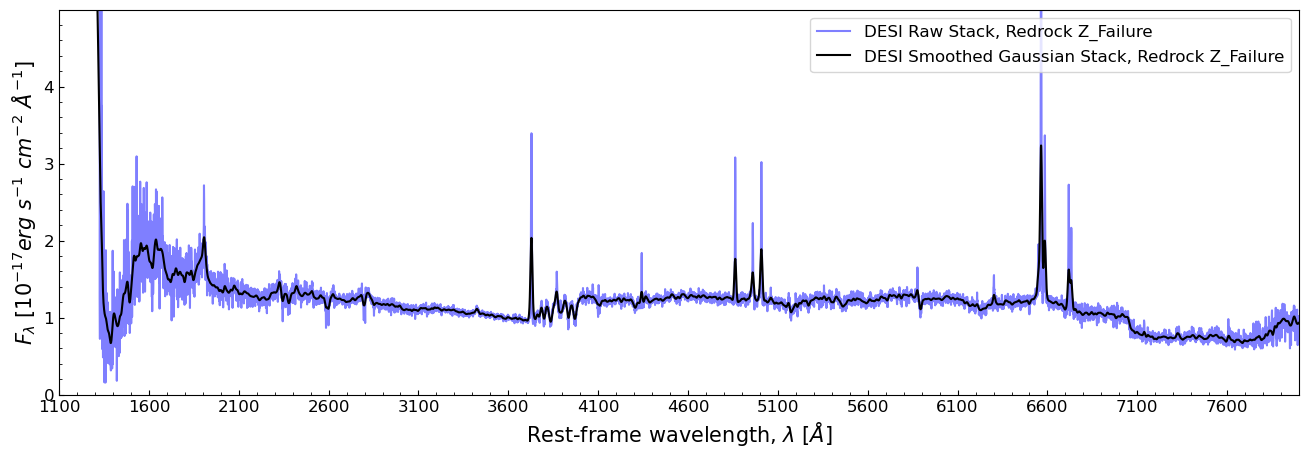

All plots saved in DESI-Z_Failure-stack_NEW.pdf


In [253]:


# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack_NEW.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln,flux, color='blue', alpha=0.5,label = f'DESI Raw Stack, Redrock {Overall_class}')
        ax.plot(wln,convolve(flux, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, Redrock {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8000)
        ax.set_ylim(0,5)
        ax.set_xticks(range(1100, 8001, 500))
        ax.set_yticks(range(0, 5, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')




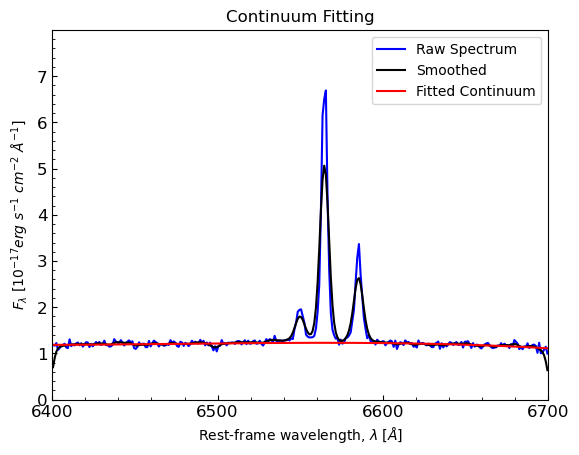

In [264]:
"""""
Continuum fit

Points to consider:
- Could change the region of wavelength to fit the continuum
- Could just fit polynomial to the continuum
- When exculing region need to cosider the N2 peaks


"""""


import warnings
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

wavelength = wln
flux = flux        

region_wavelengths = wln[(wln >= 6400) & (wln <= 6700)] 
region_fluxes = flux[(wln >= 6400) & (wln <= 6700)]       

# Create a Spectrum1D object from the spectra
spectrum = Spectrum1D(flux=region_fluxes*u.Unit('erg/s/cm^2/AA'), spectral_axis=region_wavelengths*u.AA)

# Define the region to exclude (H alpha peak)
exclude_region = SpectralRegion(6562.8*u.AA - 50*u.AA, 6562.8*u.AA + 50*u.AA)

# Fit a generic continuum model to the spectrum, excluding the H alpha peak
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    g1_fit = fit_generic_continuum(spectrum, exclude_regions=[exclude_region])

# Generate the fitted continuum values
y_continuum_fitted = g1_fit(region_wavelengths*u.AA)

# Create a new figure and axis
f, ax = plt.subplots()
ax.plot(region_wavelengths, region_fluxes, color='blue', label='Raw Spectrum')
ax.plot(region_wavelengths, convolve(region_fluxes, Gaussian1DKernel(2)), color='black', alpha=1, label='Smoothed')
ax.plot(region_wavelengths, y_continuum_fitted, color='red', alpha=1, label='Fitted Continuum') 
ax.set_title("Continuum Fitting")
ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
ax.set_xlim(6400,6700)
ax.set_ylim(0,8)
ax.set_xticks(range(6400, 6701, 100))
ax.set_yticks(range(0, 8, 1))
ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
ax.minorticks_on()
ax.legend()

   

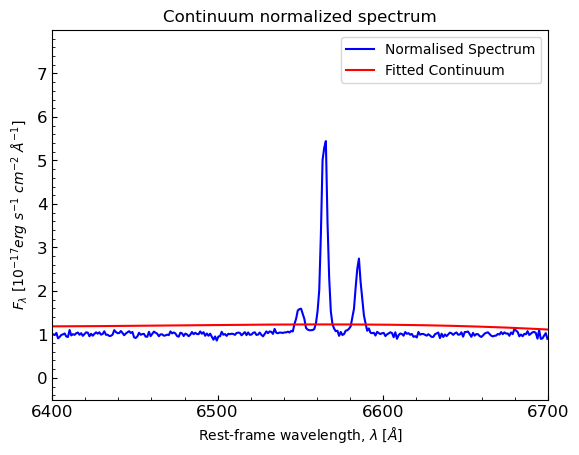

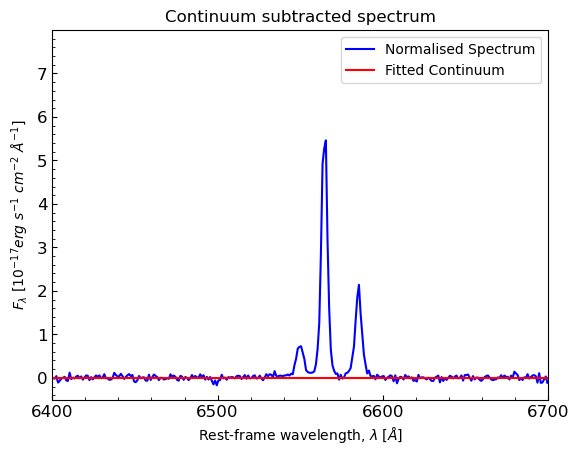

In [271]:
"""   
Get continuum Normalised and continuum subtracted spectra

"""

spec_normalized = spectrum / y_continuum_fitted


f, ax = plt.subplots()
ax.plot(spec_normalized.spectral_axis, spec_normalized.flux, color='blue', label='Normalised Spectrum')
ax.plot(region_wavelengths, y_continuum_fitted, color='red', alpha=1, label='Fitted Continuum') 
ax.set_title("Continuum normalized spectrum")  
ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
ax.set_xlim(6400,6700)
ax.set_ylim(-0.5,8)
ax.set_xticks(range(6400, 6701, 100))
ax.set_yticks(range(0, 8, 1))
ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
ax.minorticks_on()
ax.legend()

spec_subtracted = spectrum - y_continuum_fitted

f, ax = plt.subplots()
ax.plot(spec_subtracted.spectral_axis, spec_subtracted.flux, color='blue', label='Normalised Spectrum')
ax.plot(region_wavelengths, y_continuum_fitted-y_continuum_fitted, color='red', alpha=1, label='Fitted Continuum') 
ax.set_title("Continuum subtracted spectrum")  
ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
ax.set_xlim(6400,6700)
ax.set_ylim(-0.5,8)
ax.set_xticks(range(6400, 6701, 100))
ax.set_yticks(range(0, 8, 1))
ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
ax.minorticks_on()
ax.legend()

In [277]:
"""   
Find EW by applying the integral

- Could cacluate intergral with simps or another method
- Note sure this is the correct error calculation

"""

ew_flux = (y_continuum_fitted - spectrum.flux)/y_continuum_fitted


# Define the wavelength range for the H alpha line
wln_min = 6562.8 - 50  
wln_max = 6562.8 + 50  

# Find the indices of the wavelength range
indices = np.where((region_wavelengths >= wln_min) & (region_wavelengths <= wln_max))[0]

# Extract the wavelength and flux values within the range
wln_range = region_wavelengths[indices]
flux_range = ew_flux[indices]

# Integrate the flux values to find the equivalent width
ew = np.trapz(flux_range, wln_range)

print(f'Equivalent Width (EW) = {ew:.2f} Angstroms')


# Find the standard deviation of the flux values
std_flux = np.std(flux_range)

# Calculate the error in the equivalent width
ew_error = std_flux * np.sqrt(len(flux_range))

print(f'Error in EW = {ew_error:.2f} Angstroms')


Equivalent Width (EW) = -35.54 Angstroms
Error in EW = 8.26 Angstroms


In [280]:
"""   

Apply specutils equivalent width function to the continuum normalised spectra

"""

# Find the equivalent width of Halpha in spec_normalized
from specutils.analysis import equivalent_width


#region=SpectralRegion(6562.8*u.AA, 6564.8*u.AA)

# Calculate equivalent width using specutils equivalent_width function
eq_width = equivalent_width(spec_normalized)
#my worry with this is that it does not do it for the correct region

print(f'Equivalent Width (EW) = {eq_width:.2f} Angstroms')

Equivalent Width (EW) = -35.81 Angstrom Angstroms


EW: -35.85762670454919
EW: -35.5440891955133


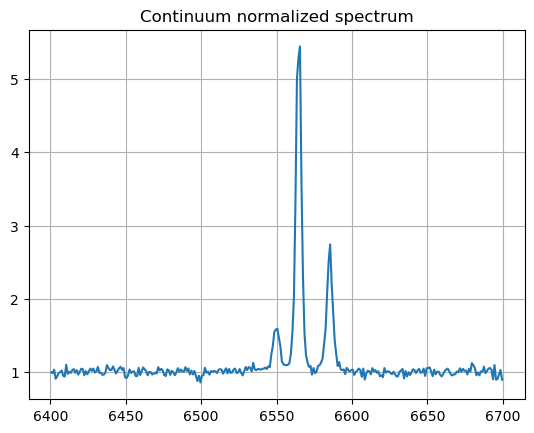

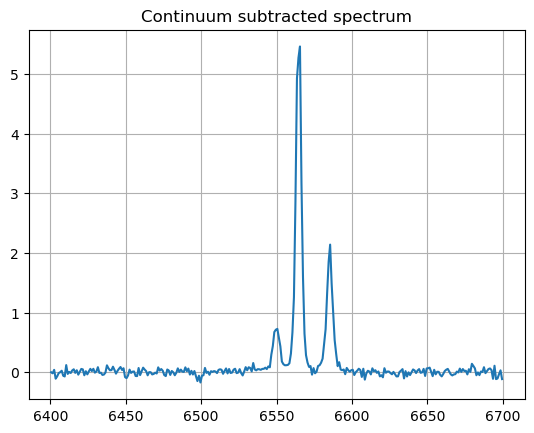

In [256]:







ew = np.trapz(ew_flux, region_wavelengths)

print('EW:', ew)

ew = np.trapz(flux_range, wln_range)

print('EW:', ew)



In [229]:
# Find the equivalent width of Halpha in spec_normalized
from specutils.analysis import equivalent_width



#region=SpectralRegion(6562.8*u.AA, 6564.8*u.AA)

# Calculate equivalent width using specutils equivalent_width function
eq_width = equivalent_width(spec_normalized)
#my worry with this is that it does not do it for the correct region

print("Equivalent Width of H-alpha line:", eq_width)


eq_width = equivalent_width(spec_subtracted)
#my worry with this is that it does not do it for the correct region

print("Equivalent Width of H-alpha line:", eq_width)




Equivalent Width of H-alpha line: -148.2852290961672 Angstrom
Equivalent Width of H-alpha line: 274.8139297705002 Angstrom


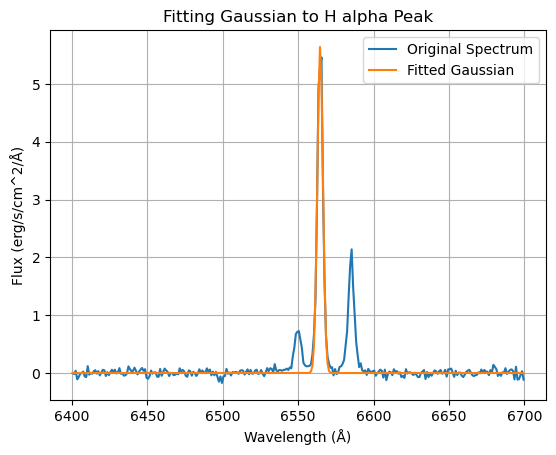

FWHM of the Gaussian: 4.3547646278773895 Angstrom
Amplitude of the Gaussian: Parameter('amplitude', value=5.652136583574721, unit=erg / (Angstrom s cm2))
Equivalent Width of H alpha line: 24.613724466082946 erg / (s cm2)
Equivalent Width of H alpha line: 277.67957037060603


In [246]:


from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

flux1 = spec_subtracted.flux.value
wln1 = spec_subtracted.spectral_axis.value

# Define the wavelength range for the H alpha line
wln_min = 6562.8 - 50  # Minimum wavelength
wln_max = 6562.8 + 50  # Maximum wavelength

# Select the region of interest
region = Spectrum1D(flux=flux1[(wln1 >= wln_min) & (wln1 <= wln_max)]*u.Unit('erg/s/cm^2/AA'), 
                    spectral_axis=wln1[(wln1 >= wln_min) & (wln1 <= wln_max)]*u.AA)

# Fit a Gaussian model to the region of interest
g_init = models.Gaussian1D(amplitude=np.max(region.flux), mean=np.mean(region.spectral_axis), stddev=1.*u.AA)
g_fit = fit_lines(region, g_init)

# Generate the fitted Gaussian values
y_fit = g_fit(wln1*u.AA)

# Plot the original spectrum and the fitted Gaussian
plt.plot(wln1, flux1, label='Original Spectrum')
plt.plot(wln1, y_fit, label='Fitted Gaussian')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (erg/s/cm^2/Å)')
plt.title('Fitting Gaussian to H alpha Peak')
plt.legend()
plt.grid(True)
plt.show()

fwhm = g_fit.fwhm
print("FWHM of the Gaussian:", fwhm)

amplitude = g_fit.amplitude
print("Amplitude of the Gaussian:", amplitude)

# Calculate the equivalent width 
equivalent_width = fwhm*amplitude
print("Equivalent Width of H alpha line:", equivalent_width)


ew_flux = (y_continuum_fitted - y_fit)/y_continuum_fitted

equivalent_width = np.trapz(ew_flux, wln)

print("Equivalent Width of H alpha line:", equivalent_width)


In [231]:
ew = np.trapz(1-(flux/ y_continuum_fitted.value), wln)

ew

150.9275886191341

In [232]:
import numpy as np
from scipy.integrate import simps

# Method 1: Using the Gaussian fit parameters

# Calculate equivalent width using the fitted Gaussian curve
ew_gaussian = np.trapz(y_fit.value, wln)

print("Equivalent Width using Gaussian Fit Method:", ew_gaussian)

# Method 2: Using the original spectra and continuum fit

wavelengths_spectrum = wln  # Adjust the range as per your data
spectrum_flux = flux  # Replace with actual spectrum flux
continuum_flux = y_continuum_fitted.value  # Replace with actual continuum fit flux

# Subtract continuum from spectrum to isolate emission line
emission_line_flux = spectrum_flux - continuum_flux

# Calculate equivalent width using original spectrum and continuum fit
ew_integral = simps(1 - (emission_line_flux / continuum_flux), wavelengths_spectrum)

print("Equivalent Width using Integration Method:", ew_integral)


Equivalent Width using Gaussian Fit Method: 24.77985573823299
Equivalent Width using Integration Method: 445.9142025109574


Equivalent Width of H-alpha line: -35.805291834873486 Angstrom


In [ ]:
##### NEED TO DECIDE WHAT BINS TO APPLY HERE
#6563
#4861




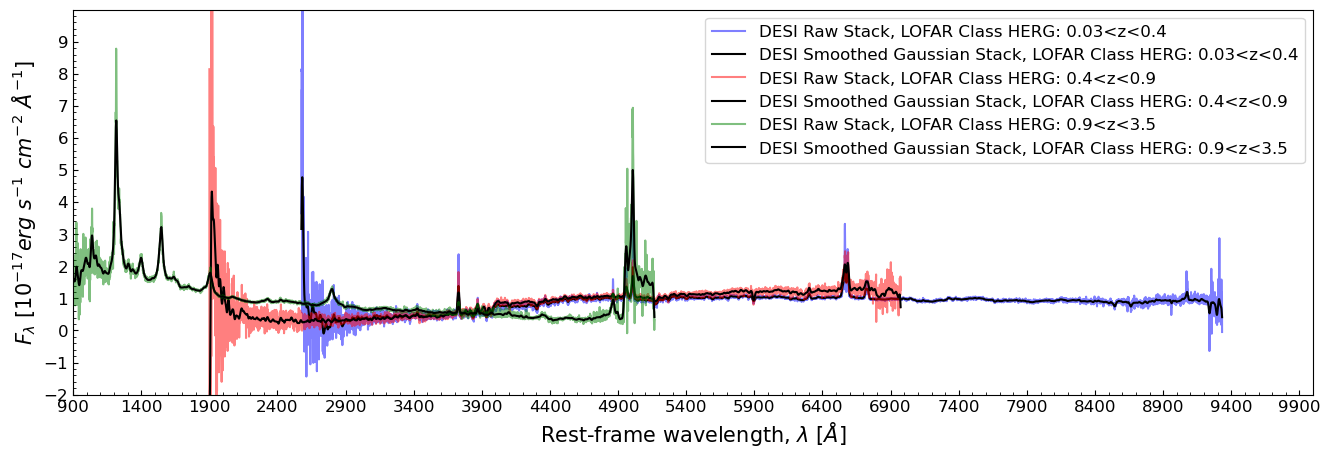

All plots saved in DESI-HERG-stacked-zbin-plots-2.pdf


In [134]:
"""

"""




# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-2.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1,flux_1, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1,convolve(flux_1, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2,flux_2, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2,convolve(flux_2, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3,flux_3, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3,convolve(flux_3, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(900,10000)
        ax.set_ylim(-2,10)
        ax.set_xticks(range(900, 10001, 500))
        ax.set_yticks(range(-2, 10, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

In [126]:

"""

Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0.1
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)


st1 = bounds(wln_1)
st2 = bounds(wln_2)
st3 = bounds(wln_3)



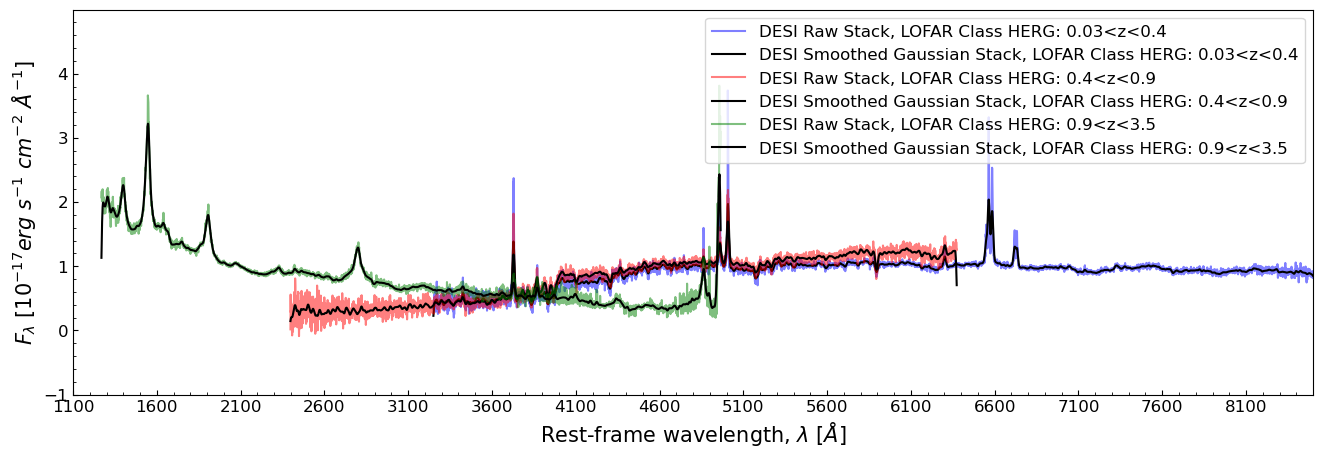

All plots saved in DESI-HERG-stacked-zbin-plots-0.1cut.pdf


In [135]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1[st1[0]:st1[1]],flux_1[st1[0]:st1[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1[st1[0]:st1[1]],convolve(flux_1[st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2[st2[0]:st2[1]],flux_2[st2[0]:st2[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2[st2[0]:st2[1]],convolve(flux_2[st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3[st3[0]:st3[1]],flux_3[st3[0]:st3[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3[st3[0]:st3[1]],convolve(flux_3[st3[0]:st3[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8500)
        ax.set_ylim(-1,5)
        ax.set_xticks(range(1100, 8501, 500))
        ax.set_yticks(range(-1, 5, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

int